### MODEL ENSEMBLE

In [1]:
import pickle
from time import time
import pandas as pd
import numpy as np
from gensim.models import KeyedVectors
import re
from nltk.corpus import stopwords 
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt 
import seaborn as sns

import itertools 
import datetime

from keras.preprocessing.sequence import pad_sequences 
from keras.models import Model 
from keras.layers import Input, Embedding, LSTM, Merge 
import keras.backend as K 
from keras.optimizers import Adadelta 
from keras.callbacks import ModelCheckpoint 
from keras.models import Sequential 
from keras.layers import Dense
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import itertools

/home/shared/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


##### Load the predictions from 5 models

In [96]:
#load Training data
lstmPredictions_train = pickle.load(open(r'model/predictions_lstm_full_run_train_csv_final.p', 'rb'))
lstmPredictions_train = np.asarray(lstmPredictions_train)
xgboostPredictions_train = pickle.load(open(r'baseline_pickles_new/predictions_full_XGB_train.p', 'rb'), encoding='iso-8859-1')
rfPredictions_train = pickle.load(open(r'baseline_pickles_new/predictions_full_RF_train.p', 'rb'), encoding='iso-8859-1')
lgbmPredictions_train = pickle.load(open(r'baseline_pickles_new/predictions_full_LGBM_train.p', 'rb'), encoding='iso-8859-1')
lrPredictions_train = pickle.load(open(r'baseline_pickles_new/predictions_full_LR_train.p', 'rb'), encoding='iso-8859-1')


#load Validation data
lstmPredictions_valid = pickle.load(open(r'model/predictions_lstm_full_run_valid_csv_final.p', 'rb'))
lstmPredictions_valid = np.asarray(lstmPredictions_valid)
xgboostPredictions_valid = pickle.load(open(r'baseline_pickles_new/predictions_full_XGB_valid.p', 'rb'), encoding='iso-8859-1')
rfPredictions_valid = pickle.load(open(r'baseline_pickles_new/predictions_full_RF_valid.p', 'rb'), encoding='iso-8859-1')
lgbmPredictions_valid = pickle.load(open(r'baseline_pickles_new/predictions_full_LGBM_valid.p', 'rb'), encoding='iso-8859-1')
lrPredictions_valid = pickle.load(open(r'baseline_pickles_new/predictions_full_LR_valid.p', 'rb'), encoding='iso-8859-1')


#load Testing data
lstmPredictions_test = pickle.load(open(r'model/predictions_lstm_full_run_test_csv_final.p', 'rb'))
lstmPredictions_test = np.asarray(lstmPredictions_test)
xgboostPredictions_test = pickle.load(open(r'baseline_pickles_new/predictions_full_XGB_test.p', 'rb'), encoding='iso-8859-1')
rfPredictions_test = pickle.load(open(r'baseline_pickles_new/predictions_full_RF_test.p', 'rb'), encoding='iso-8859-1')
lgbmPredictions_test = pickle.load(open(r'baseline_pickles_new/predictions_full_LGBM_test.p', 'rb'), encoding='iso-8859-1')
lrPredictions_test = pickle.load(open(r'baseline_pickles_new/predictions_full_LR_test.p', 'rb'), encoding='iso-8859-1')


##### Validate shapes

In [97]:
print(lstmPredictions_train.shape)
print(type(xgboostPredictions_train))
print(lstmPredictions_train.shape)
print(type(lstmPredictions_train))

(304290,)
<class 'numpy.ndarray'>
(304290,)
<class 'numpy.ndarray'>


In [15]:
print(xgboostPredictions_test.shape)
print(type(xgboostPredictions_test))
print(lstmPredictions_test.shape)
print(type(lstmPredictions_test))

(50000,)
<class 'numpy.ndarray'>
(50000,)
<class 'numpy.ndarray'>


##### Construct input features for NN

In [193]:
X_train = np.vstack((lstmPredictions_train.T, lgbmPredictions_train.T, rfPredictions_train.T, lrPredictions_train.T))
print(X_train.shape)
X_train = X_train.T
print(X_train.shape)


X_valid = np.vstack((lstmPredictions_valid.T, lgbmPredictions_valid.T, rfPredictions_valid.T, lrPredictions_valid.T))
print(X_valid.shape)
X_valid = X_valid.T
print(X_valid.shape)


X_test = np.vstack((lstmPredictions_test.T, lgbmPredictions_test.T, rfPredictions_test.T, lrPredictions_test.T))
print(X_test.shape)
X_test = X_test.T
print(X_test.shape)

(4, 304290)
(304290, 4)
(4, 50000)
(50000, 4)
(4, 50000)
(50000, 4)


##### Load labels

In [17]:
train_df = pd.read_csv('data/train.csv', encoding="utf-8").fillna("")

In [18]:
train_df.shape

(404290, 6)

In [ ]:
labels = train_df['is_duplicate']
print(type(labels))
labels = labels.as_matrix()

##### Split dataset into training, validation and testing

In [103]:
train_size = 304290
valid_size = 50000
test_size = 50000

Y_train = labels[0:train_size]
print(Y_train.shape)


Y_valid = labels[train_size:train_size+valid_size]
print(Y_valid.shape)


Y_test = labels[train_size+valid_size:train_size+valid_size+test_size]
print(Y_test.shape)

(304290,)
(50000,)
(50000,)


##### Build the model

In [194]:
#create model
combinedModel = Sequential()
combinedModel.add(Dense(15, input_dim=X_train.shape[1], activation='elu'))
combinedModel.add(Dense(5, activation='elu'))
combinedModel.add(Dense(1, activation='sigmoid'))

In [196]:
#compile model
combinedModel.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

##### Run the model

In [197]:
#fit the model
combinedModel.fit(X_train, Y_train, epochs=20, batch_size=64, validation_data=(X_valid, Y_valid))

Train on 304290 samples, validate on 50000 samples
Epoch 1/20
304290/304290 [==============================] - 19s 62us/step - loss: 0.0603 - acc: 0.9186 - val_loss: 0.0934 - val_acc: 0.8718
Epoch 2/20
304290/304290 [==============================] - 18s 60us/step - loss: 0.0558 - acc: 0.9229 - val_loss: 0.0970 - val_acc: 0.8657
Epoch 3/20
304290/304290 [==============================] - 18s 61us/step - loss: 0.0555 - acc: 0.9235 - val_loss: 0.0941 - val_acc: 0.8697
Epoch 4/20
304290/304290 [==============================] - 18s 61us/step - loss: 0.0553 - acc: 0.9238 - val_loss: 0.0954 - val_acc: 0.8680
Epoch 5/20
304290/304290 [==============================] - 18s 60us/step - loss: 0.0551 - acc: 0.9242 - val_loss: 0.0964 - val_acc: 0.8669
Epoch 6/20
304290/304290 [==============================] - 18s 61us/step - loss: 0.0550 - acc: 0.9243 - val_loss: 0.0959 - val_acc: 0.8670
Epoch 7/20
304290/304290 [==============================] - 18s 60us/step - loss: 0.0548 - acc: 0.9248 - val_

##### Evaluate the model

In [198]:
#evaluate model
predictions_test = combinedModel.predict(X_test)

predictions_test = [item for sublist in predictions_test for item in sublist]

predictions_test_bool = [(prediction > 0.5) for prediction in predictions_test]


##### Plot results

Confusion matrix, without normalization
[[27873  4521]
 [ 2652 14954]]


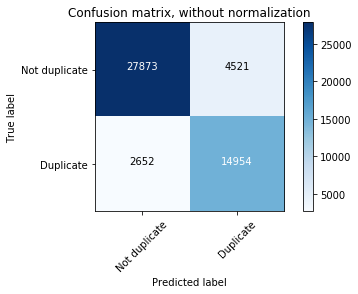

In [199]:

def plot_confusion_matrix(cm, classes,

                          normalize=False,

                          title='Confusion matrix',

                          cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')



    print(cm)



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()

    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    fmt = '.2f' if normalize else 'd'

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, format(cm[i, j], fmt),

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")



    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')



# Compute confusion matrix

y_test = Y_test

y_pred = predictions_test_bool
#y_pred = predictions_test


cnf_matrix = confusion_matrix(y_test, y_pred)



np.set_printoptions(precision=2)



# Plot non-normalized confusion matrix

plt.figure()

plot_confusion_matrix(cnf_matrix, classes=['Not duplicate','Duplicate'],

                      title='Confusion matrix, without normalization')

Accuracy:  0.85654
Recall:  0.8493695331137112
Precision:  0.7678562259306804
F1 score:  0.8065586149240851
ROC AUC score:  0.8549033255492616
Average precision-recall score: 0.91


Text(0.5,1,'2-class Precision-Recall curve: AP=0.91')

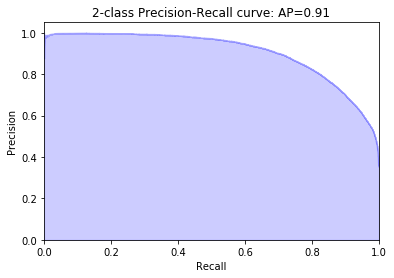

In [200]:

y_test = y_test

y_pred = predictions_test_bool

y_pred_prob = predictions_test



rec = recall_score(y_test, y_pred)

prec = precision_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)

roc_auc = roc_auc_score(y_test, y_pred)



print("Accuracy: ", acc)

print("Recall: ", rec)

print("Precision: ", prec)

print("F1 score: ", f1)

print("ROC AUC score: ", roc_auc)





average_precision = average_precision_score(y_test, y_pred_prob)



print('Average precision-recall score: {0:0.2f}'.format(

      average_precision))




precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)



plt.step(recall, precision, color='b', alpha=0.2,

         where='post')

plt.fill_between(recall, precision, step='post', alpha=0.2,

                 color='b')



plt.xlabel('Recall')

plt.ylabel('Precision')

plt.ylim([0.0, 1.05])

plt.xlim([0.0, 1.0])

plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(

          average_precision))